## Description
This is to demonstrate the use of neural network for multi-categorical classification of text based on its contents. <br>
The data is a set of Reuters news. Each text contains specific words, based on which the neural network classifies  <br>
the news into 46 categries based on the news topics.

### 1. Setup

In [2]:
# import standard libs and setup the keras backend
import os

# Note that Keras should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
os.environ["KERAS_BACKEND"] = "tensorflow"

# import third-party libs
import keras
from keras.datasets import reuters
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

# import local libs
from classifiers.utils import set_logging_level, detect_devices, random_classifier
from classifiers.text import Vectorizer, Splitter

# List available physical devices
print("CPUs Available: ", detect_devices('CPU'))
print("GPUs Available: ", detect_devices('GPU'))

# plots will be printed in the notebook
%matplotlib inline 

CPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2. Data preparation

In [3]:
from keras.utils import to_categorical

print('Preparing data...', end='')

# load data - 50.000 movie reviews, loaded will be the most frequent 10.000 words per text
n_words = 10000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=n_words)

# vectorize the training and testing data
# before being loaded into the network
vectorizer = Vectorizer(dtype=np.uint8) # using an int data type instead of float to prevent precision loss
x_train_vec = vectorizer.vectorize_text(train_data, n_words)
x_test_vec = vectorizer.vectorize_text(test_data, n_words)

# also vectorize data labels
y_train_vec = vectorizer.vectorize_labels(train_labels)
y_test_vec = vectorizer.vectorize_labels(test_labels)

# split the original training data into two sets so
# that first 25.000 reviews will be used for training
# and the last 10.000 reviews for validation of the model
splitter = Splitter(split_idx = 1000)
x_train, x_valid = splitter.split_train_validation(x_train_vec)
y_train, y_valid = splitter.split_train_validation(y_train_vec)

print('done.')

Preparing data...done.


### 3. Model compilation, training and evaluation

Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3746 - loss: 2.9828 - val_accuracy: 0.6680 - val_loss: 1.5681
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6985 - loss: 1.4009 - val_accuracy: 0.7150 - val_loss: 1.2562
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 1.0546 - val_accuracy: 0.7610 - val_loss: 1.0853
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8218 - loss: 0.8266 - val_accuracy: 0.7710 - val_loss: 1.0040
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.6442 - val_accuracy: 0.7980 - val_loss: 0.9212
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8881 - loss: 0.5360 - val_accuracy: 0.7940 - val_loss: 0.8750
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9108 - loss: 0.4233 - val_accuracy: 0.7980 - val_loss: 0.8774
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9315 - loss: 0.3499 - val_accuracy: 0.8100 - val_loss: 0.841

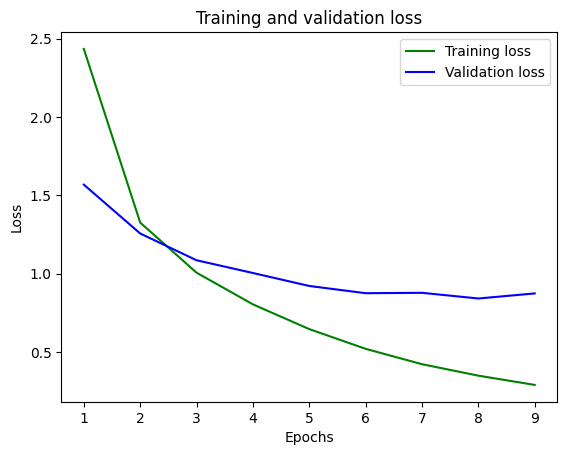

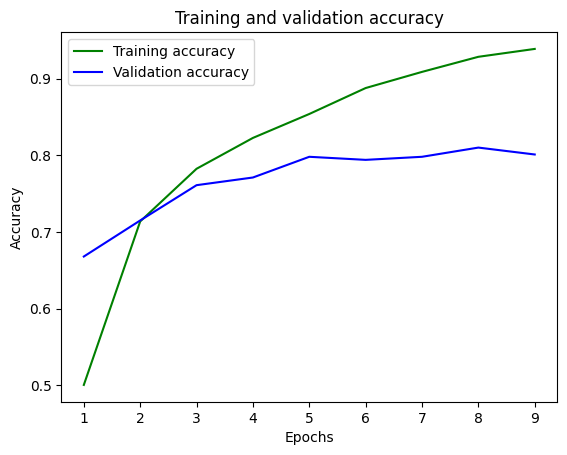

In [9]:
# initialize the network model
model = models.Sequential()
model.add(layers.Input(shape=(n_words,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# since labels are encoded as integers, the loss 
# function must be adjusted accordingly: instead
# of using categorical_crossentropy, we must use
# sparse_categorical_crossentropy - same as the 
# former, but implements different interface
model.compile(
  optimizer=optimizers.RMSprop(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# start training the model
history = model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512,
    validation_data=(
        x_valid,
        y_valid
    )
)

# evaluate the model 
rand_classif = random_classifier(y_test_vec) # baseline classifier
test_loss, test_acc = model.evaluate(x_test_vec, y_test_vec)

print(
    f'Baseline classifier accuracy: {rand_classif:.2f} '
    f'Test accuracy: {test_acc:.2f} '
    f'Test loss: {test_loss:.2f}'
)

training_loss = history.history['loss']
training_val_loss = history.history['val_loss']
epochs=range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.plot(epochs, training_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

# clear prev plot
plt.clf()

training_accuracy = history.history['accuracy']
training_val_accuracy = history.history['val_accuracy']

plt.plot(epochs, training_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, training_val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()